In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np

from collections import defaultdict
import sys
import random
from tqdm import tqdm, tqdm_notebook

from blackjack_double import BlackjackEnv as EnvDouble
from blackjack_count import BlackjackEnv as EnvCount

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('Blackjack-v0')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


#### Возьмем фиксированную стратегию, оценим Reward на 500 тысячах раундов.

In [3]:
# фиксированная стратегия
def defined_policy(state):
    score, _, _ = state
    return 0 if score > 18 else 1

# генератор эпизодов
def generate_episode(env, policy):
    episode = []
    state = env.reset()
    while True:
        action = policy(state)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [4]:
def first_visit_mc_prediction(policy, env, n_episodes):
    value_table = defaultdict(float)
    N = defaultdict(int)
    cum_reward = []
    for _ in range(n_episodes):
        episode = generate_episode(env, policy)
        cum_reward.append(episode[-1][-1])
        returns = 0
        for t in range(len(episode) - 1, -1, -1):
            R = episode[t][2]
            S = episode[t][0]
            returns += R
            if S not in [x[0] for x in episode[:t]]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    return value_table, cum_reward

In [5]:
value, cum_reward = first_visit_mc_prediction(defined_policy, env, n_episodes = 500000)

In [6]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(11, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)         
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V.get((player, dealer, ace), 0)
    X, Y = np.meshgrid(dealer_show, player_sum)
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])   
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:    
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer sum')
        ax.set_zlabel('state-value')

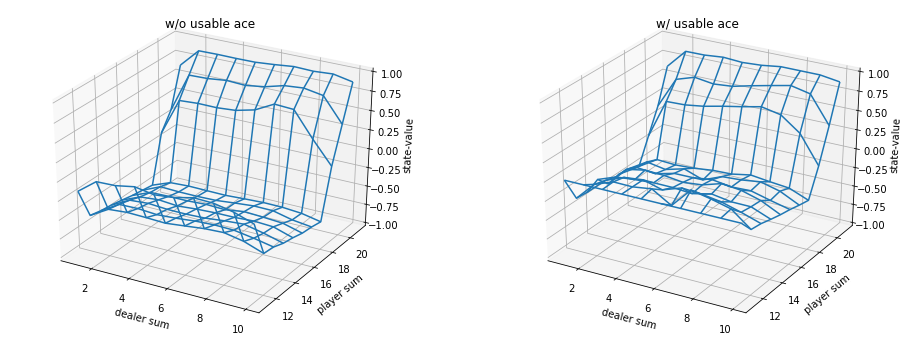

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6),subplot_kw={'projection': '3d'})
axes[0].set_title('w/o usable ace')
axes[1].set_title('w/ usable ace')
plot_blackjack(value, axes[0], axes[1])

In [8]:
print('Average Reward ', np.mean(cum_reward))

Average Reward  -0.201196


#### Видно, что V почти везде отрицательное. Средний Reward меньше 0.19.
#### Попробуем обучить Monte-Carlo Control.

In [9]:
# возвращаем вероятность лучшего действия согласно epsilon
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

# обновляем Q
def update_Q(env, episode, Q, alpha, gamma):
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    return Q

# policy
def mc_control_policy(Q, state, epsilon, nA):
    if state in Q:
        return np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))
    else:
        return None
    
# новый генератор эпизодов
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        
        action = mc_control_policy(Q, state, epsilon, nA)
        if action is None:
            action = env.action_space.sample()
            
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

# каждые 100 тысяч итераций оцениваем, насколько хорошо играет наша стратегия
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99995, eps_min=0.01):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    cum_reward = []
    reward_hist = []
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        cum_reward.append(episode[-1][-1])
        Q = update_Q(env, episode, Q, alpha, gamma)
        
        if i_episode % 100000 == 0:
            avg_reward = []
            for i in tqdm_notebook(range(100000)):
                episode = generate_episode_from_Q(env, Q, .0, nA)
                avg_reward.append(episode[-1][-1])
            reward_hist.append(np.mean(avg_reward))
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, cum_reward, reward_hist

In [10]:
policy, Q, cum_reward, reward_hist = mc_control(env, num_episodes = 1000000, alpha = 0.015, 
                                                gamma=1.0, eps_start=1.0, eps_decay=.99995, eps_min=0.01)

Episode 100000/1000000.

<ipython-input-9-9201c20b6615>:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(100000)):



Episode 200000/1000000.


Episode 300000/1000000.


Episode 400000/1000000.


Episode 500000/1000000.


Episode 600000/1000000.


Episode 700000/1000000.


Episode 800000/1000000.


Episode 900000/1000000.


Episode 1000000/1000000.

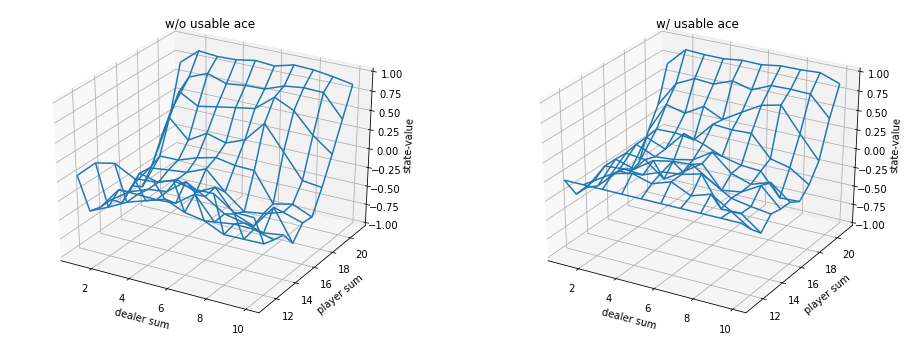

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6),subplot_kw={'projection': '3d'})
axes[0].set_title('w/o usable ace')
axes[1].set_title('w/ usable ace')
plot_blackjack({k: max(v) for k, v in Q.items()}, axes[0], axes[1])

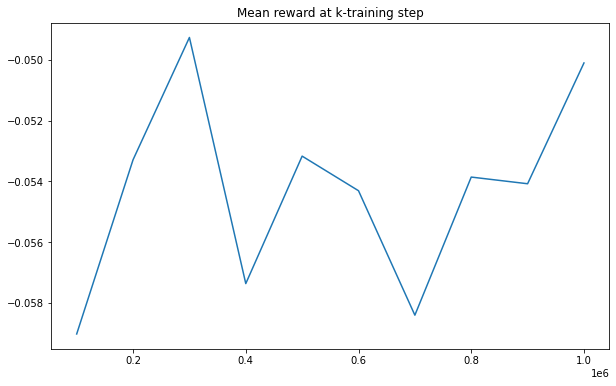

In [12]:
plt.figure(figsize = (10, 6))
plt.title('Mean reward at k-training step')
plt.plot(np.arange(1, len(reward_hist)+1) * 100000, reward_hist)
plt.show()

#### Видно, что средний Reward стал гораздо лучше чем у фиксированной стратегии (даже после первых 100000 итераций), однако он все равно ниже 0.
#### Реализуем блэкджек с удвоением.

In [13]:
env = EnvDouble(natural=True)

In [14]:
policy, Q, cum_reward, reward_hist = mc_control(env, num_episodes = 1000000, alpha = 0.015, 
                                                gamma=1.0, eps_start=1.0, eps_decay=.99995, eps_min=0.01)

Episode 100000/1000000.

<ipython-input-9-9201c20b6615>:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(100000)):



Episode 200000/1000000.


Episode 300000/1000000.


Episode 400000/1000000.


Episode 500000/1000000.


Episode 600000/1000000.


Episode 700000/1000000.


Episode 800000/1000000.


Episode 900000/1000000.


Episode 1000000/1000000.

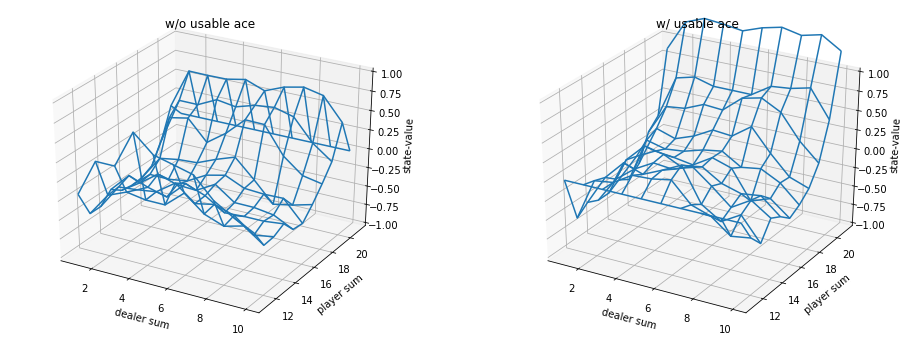

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6),subplot_kw={'projection': '3d'})
axes[0].set_title('w/o usable ace')
axes[1].set_title('w/ usable ace')
plot_blackjack({k: max(v) for k, v in Q.items()}, axes[0], axes[1])

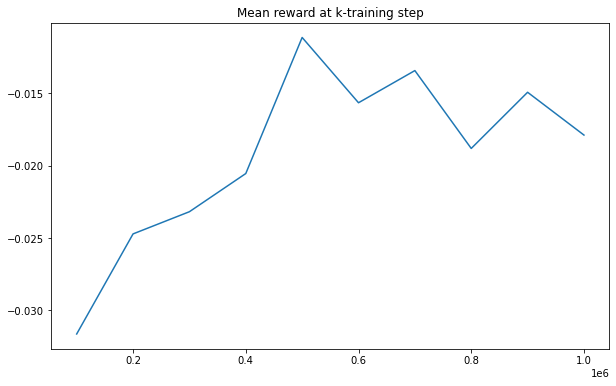

In [16]:
plt.figure(figsize = (10, 6))
plt.title('Mean reward at k-training step')
plt.plot(np.arange(1, len(reward_hist)+1) * 100000, reward_hist)
plt.show()

#### Средний Reward стал еще выше, однако он все равно ниже 0.

In [17]:
env = EnvCount(natural=True)

In [23]:
%%time
policy, Q, cum_reward, reward_hist = mc_control(env, 
                                                num_episodes = 10000000, 
                                                alpha = 0.015, 
                                                gamma = 0.99, 
                                                eps_decay = 0.99999995,
                                               )

Episode 100000/10000000.

<ipython-input-9-9201c20b6615>:59: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(100000)):



Episode 200000/10000000.


Episode 300000/10000000.


Episode 400000/10000000.


Episode 500000/10000000.


Episode 600000/10000000.


Episode 700000/10000000.


Episode 800000/10000000.


Episode 900000/10000000.


Episode 1000000/10000000.


Episode 1100000/10000000.


Episode 1200000/10000000.


Episode 1300000/10000000.


Episode 1400000/10000000.


Episode 1500000/10000000.


Episode 1600000/10000000.


Episode 1700000/10000000.


Episode 1800000/10000000.


Episode 1900000/10000000.


Episode 2000000/10000000.


Episode 2100000/10000000.


Episode 2200000/10000000.


Episode 2300000/10000000.


Episode 2400000/10000000.


Episode 2500000/10000000.


Episode 2600000/10000000.


Episode 2700000/10000000.


Episode 2800000/10000000.


Episode 2900000/10000000.


Episode 3000000/10000000.


Episode 3100000/10000000.


Episode 3200000/10000000.


Episode 3300000/10000000.


Episode 3400000/10000000.


Episode 3500000/10000000.


Episode 3600000/10000000.


Episode 3700000/10000000.


Episode 3800000/10000000.


Episode 3900000/10000000.


Episode 4000000/10000000.


Episode 4100000/10000000.


Episode 4200000/10000000.


Episode 4300000/10000000.


Episode 4400000/10000000.


Episode 4500000/10000000.


Episode 4600000/10000000.


Episode 4700000/10000000.


Episode 4800000/10000000.


Episode 4900000/10000000.


Episode 5000000/10000000.


Episode 5100000/10000000.


Episode 5200000/10000000.


Episode 5300000/10000000.


Episode 5400000/10000000.


Episode 5500000/10000000.


Episode 5600000/10000000.


Episode 5700000/10000000.


Episode 5800000/10000000.


Episode 5900000/10000000.


Episode 6000000/10000000.


Episode 6100000/10000000.


Episode 6200000/10000000.


Episode 6300000/10000000.


Episode 6400000/10000000.


Episode 6500000/10000000.


Episode 6600000/10000000.


Episode 6700000/10000000.


Episode 6800000/10000000.


Episode 6900000/10000000.


Episode 7000000/10000000.


Episode 7100000/10000000.


Episode 7200000/10000000.


Episode 7300000/10000000.


Episode 7400000/10000000.


Episode 7500000/10000000.


Episode 7600000/10000000.


Episode 7700000/10000000.


Episode 7800000/10000000.


Episode 7900000/10000000.


Episode 8000000/10000000.


Episode 8100000/10000000.


Episode 8200000/10000000.


Episode 8300000/10000000.


Episode 8400000/10000000.


Episode 8500000/10000000.


Episode 8600000/10000000.


Episode 8700000/10000000.


Episode 8800000/10000000.


Episode 8900000/10000000.


Episode 9000000/10000000.


Episode 9100000/10000000.


Episode 9200000/10000000.


Episode 9300000/10000000.


Episode 9400000/10000000.


Episode 9500000/10000000.


Episode 9600000/10000000.


Episode 9700000/10000000.


Episode 9800000/10000000.


Episode 9900000/10000000.


Episode 10000000/10000000.


CPU times: user 1h 32min 26s, sys: 12min 5s, total: 1h 44min 31s
Wall time: 1h 31min 15s


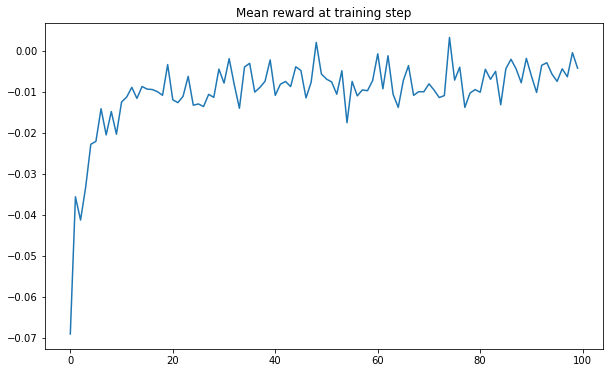

[-0.00749, -0.00443, -0.00637, -0.00049, -0.00427]

In [24]:
plt.figure(figsize = (10, 6))
plt.title('Mean reward at training step')
plt.plot(reward_hist)
plt.show()
reward_hist[-5:]

In [25]:
np.max(reward_hist)

0.00322

#### Оказывается, что с подсчетом карт пространство поиска увеличивается на порядок и exploration нужно делать гораздо дольше (поставим очень большой коэффициент затухания epsilon) и тогда получается выйти в небольшой плюс.